In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set-based (Jaccard) similarity

Exact matches are easy to test, and tests for exact matches give yes-no answers.  It is sometimes useful to know if two strings are similar, and the string matching procedure needs to be able to give answers for input strings that are not the same length.  The most straightforward approach of testing character-by-character to see the fraction of characters that match does not work well for variable-length strings or strings that can be similar if the order of their contents is changed.  

Another approach to imprecise string matching that can handle inputs of different length is the strategy of breaking the strings into substrings and check the fraction of exact matches among substrings.  How many of the parts of `string1` have exact matches for parts of `string2`?   If two strings are identical for most of their length, most of the substrings will still match even if the strings are not identical.

We will digest strings into pieces for analysis called tokens, count the tokens, and measure similarity by counting tokens shared and not shared.  This procedure was independently developed in meteorology(in the 1880s)[^*], ecology (in the 1910s)[^**], and computer science^[***].  

The similarity score takes slightly different forms depending on whether we count tokens with presence-or-absence only (sets), or whether we count the number of occurrences of each token (multi-sets).

## Tokenization

To start with, to find partial matches we need objects that represent less than all of the objects we are comparing.  Tokenization is the process of breaking a string (or document) into pieces that will be the objects of analysis.

The first step in finding set-based Jaccard similarity is to tokenize the input string.  Tokens can be individual words, pairs of words, triplets (or more) of words, individual letters, letter pairs, or more, or parts of words.  For some applications, tokens smaller than words are indicated; some tokenizers split words into meaningful parts (by encoding plural noun endings and inflected verb endings as separate tokens).


One tokenization approach (suited for documents) is to tokenize on words:

In [2]:
content = "Crash data shows information about each traffic crash on city streets."
content.split()

['Crash',
 'data',
 'shows',
 'information',
 'about',
 'each',
 'traffic',
 'crash',
 'on',
 'city',
 'streets.']

Note that this attaches punctuation marks to words if there are no intervening spaces.  Depending on your application you may want to remove (or preserve) punctuation, spacing, capitalization, or other features of the encoding.

## n-gram tokenization

Another approach to digesting text into tokens is to use fixed-length, overlapping substrings.  This breaks text up into constant-sized pieces.  The overlapping, fixed-length 
tokens are called n-grams or k-mers.  

As an example, the word `WORD` can be digested into the two-letter subsets (called bigrams) `WO`, `OR`, and `RD`.  This particular digestion treats the first and final letter off the text differently; W and D are included only once (while all the other letters are included twice).  A convention that mitigates this "edge effect" is to add symbols to the beginning and the end of the string before digesting it that allow the edge letters to be included in every possible position in a bigram.  Breaking `#WORD#` into n-grams of length 2 (bigrams) results in `#W`, `WO`, `OR`, `RD`, and `D#`.  

This function adds "#" before and after the string and digests a string of length n into n+1 bigrams:

In [3]:
def tokenizebigrams(s):
    '''Return a list of all two-character subsets
    of a string, including each input character twice.'''
    #  add dummy symbols at beginning and end:
    paddeds = "#" + s + "#"
    bigrams = []
    for i in range(len(paddeds)-2 ):
        bigrams.append( paddeds[i:i+2])
    return bigrams

Note that each character in the input appears in two of the bigrams.

And before we use this, we can devise a test that confirms that `tokenizebigrams` gives the correct output for a brief input:

In [4]:
tokenizebigrams("HELP") == [ "#H", "HE", "EL", "LP", "P#" ]

False

In [5]:
tokenizebigrams("HELP")

['#H', 'HE', 'EL', 'LP']

This is not the right answer: every letter in the input string is included in two bigrams except "P".  

It is good that we tested this, since there is an off-by-one error that I would not have seen just staring at it.  The final letter "P" is only present in one bigram, not two as intended.

In [6]:
def tokenizebigrams(s):
    '''Return a list of all two-character subsets
    of a string, including each input character twice.'''
    #  add dummy symbols at beginning and end:
    paddeds = "#" + s + "#"
    bigrams = []
    for i in range(len(paddeds)-1 ):
        bigrams.append( paddeds[i:i+2])
    return bigrams
tokenizebigrams("HELLO")

['#H', 'HE', 'EL', 'LL', 'LO', 'O#']

Now that we have a way to turn strings into lists of tokens, we need to count tokens.  Python's `set` datatype makes counting distinct tokens particularly simple.  The builtin `len()` command returns the number of (distinct) elements in a set, and the builtin `set()` will return a set from a list.

In [7]:
tokens1 = set(tokenizebigrams("HELLO"))
tokens2 = set(tokenizebigrams("HELP"))
print(tokens1 )
print(tokens2)

{'O#', 'LL', 'HE', '#H', 'EL', 'LO'}
{'P#', 'LP', 'HE', '#H', 'EL'}


Note that sets do not preserve the order of the elements, only their identity (and presence/absence).

Now we can construct the set all the tokens in common with the `set.union()` method:

In [8]:
print(tokens1.union(tokens2))

{'P#', 'O#', 'LP', 'LL', 'HE', '#H', 'EL', 'LO'}


And the set of all common tokens using `set.intersection()` :
    

In [9]:
tokens1.intersection(tokens2)

{'#H', 'EL', 'HE'}

In [10]:
print( len(tokens1), "tokens in HELLO")
print( len(tokens2), "tokens in HELP")
print( len(tokens1.union(tokens2)), "tokens in union")
print( len(tokens1.intersection(tokens2)), "tokens in intersection")


6 tokens in HELLO
5 tokens in HELP
8 tokens in union
3 tokens in intersection


## Jaccard similarity

The Jaccard index is defined as the ratio of the number of elements in the intersection to the number of elements in the union:

$$ J(s_1, s_2)  =  { n_{12} \over n_1 + n_2 - n_{12} } $$

where $n_1$ are the number of tokens in $s_1$ and $s_2$, respectively, and $n_{12}$ is the number of tokens that are shared by both $s_1$ and $s_2$.  

If we need a distance, the Jaccard distance is just one minus the Jaccard similarity:
    
$$ d_{Jaccard}(s_1, s_2) = 1 - J(s_1, s_2)  $$

Where $n_{12}$ is the number of tokens common to $s_1$ and $s_2$ and $  { (n_1 + n_2 - n_{12}) }$  is the number of tokens in either $s_1$, $s_2$, or both.  (Note that $n_1 + n_2$ would double-count tokens in the intersection.)

We can put these set-counting functions and the definition into a function:

In [11]:
def J(s1, s2):
    '''return jaccard similarity between two strings s1 and s2'''
    t1 = set(tokenizebigrams(s1))
    t2 = set(tokenizebigrams(s2))
    #print(len(t1), len(t2), len(t1.union(t2)), len(t1.intersection(t2)))
    return ( len(t1.intersection(t2)) / len(t2.union(t1) ) )

A brief investigation of test cases shows that Jaccard similarity of strings with no tokens in common is zero:

In [12]:
J("cat", "dog")

0.0

and Jaccard similarity of identical strings, which have identical sets of tokens, is 1:


In [13]:
J("exact", "exact")

1.0

From the definition as the ratio of number-in-intersection to number-in-union, we see that the Jaccard similarity between HELP and HELLO is 3/8.  

Since we know the answer, we should test our function: 

In [14]:
J("HELLO", "HELP")

0.375

This is acceptable.   We can now calculate a number between 0 and 1 that tells us something about whether strings are similar or not.

## Example: similarities between number words

As a toy example, let us find the Jaccard similarity between the first twenty counting numbers in English:


In [15]:
numbers2 = ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten",
           "eleven", "twelve", "thirteen", "fourteen", "fifteen", "sixteen", "seventeen",
           "eighteen", "nineteen", "twenty"]

In [16]:
d = np.zeros((20,20))
# Calculate distance between all pairs of strings in numbers2
for i in range(len(numbers2)):
    for j in range(len(numbers2)):
        d[i][j] = J ( numbers2[i], numbers2[j])


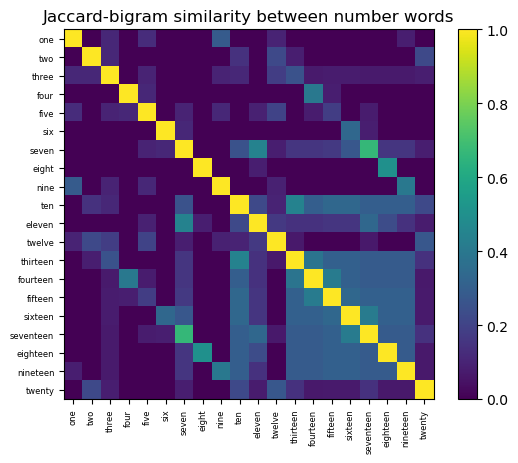

In [17]:
plt.imshow(d)
plt.colorbar()
plt.title("Jaccard-bigram similarity between number words")
plt.yticks(np.arange(len(numbers2)), numbers2, fontsize=6);
plt.xticks(np.arange(len(numbers2)), numbers2, fontsize=6, rotation=90);

In this heatmap we see that all of the numbers ending in "teen" seem similar to each other, and the digits thirteen through nineteen have more similarity with corresponding digits between three and nine than with non-corresponding digits.   Eleven and seven are closer than most pairs in the set.


## Example: searching for similar (mistaken?) names 

Let us examine some real data and look for mis-encodings with Jaccard similarity fuzzy matching.


This is a histogram of about 4000 distinct names of New York City police officers against whom complaints were registered in the timeframe 2002-2005.



In [18]:
nametable= pd.read_csv("../../data/nametable.csv")
nametable

,NAME,COUNT
0,"Reich,Mathew",75
1,"Sbarra,Daniel",75
2,"Messina,Gary",73
3,"Tallarine,Joseph",73
4,"Mccormack,Christophe",72
...,...,...
3953,"Gentile,Giuseppe",1
3954,"Reulbach,Nicholas",1
3955,"Sasso,Anthony",1
3956,"Smiarowski,Karol",1


In [19]:
namelist= list(nametable.NAME)
namelist[0:5]

['Reich,Mathew',
 'Sbarra,Daniel',
 'Messina,Gary',
 'Tallarine,Joseph',
 'Mccormack,Christophe']

Here we build a list of `name1`, `number1`, `name2`, `number2`, and Jaccard similarity between every pair of names by looping over len(namelist) twice.  This gives us about 16 million rows.  To save a little time, we only calculate the distance in the half of the pairs where j < i; this gives us only 8 million rows to calculate.

In [20]:
l = []
for i in range(len(namelist)):
    for j in range(i):
        l.append( (namelist[i], namelist[j], J  (namelist[i], namelist[j])  ))
l[0:5]

[('Sbarra,Daniel', 'Reich,Mathew', 0.0),
 ('Messina,Gary', 'Reich,Mathew', 0.0),
 ('Messina,Gary', 'Sbarra,Daniel', 0.08),
 ('Tallarine,Joseph', 'Reich,Mathew', 0.0),
 ('Tallarine,Joseph', 'Sbarra,Daniel', 0.03333333333333333)]

We should check that we got 8 million rows as expected:

In [21]:
len(l)

7830903

And let us repackage this into a dataframe so it is easy to sort and subset:


In [25]:
namesim= pd.DataFrame(l, columns=["name1", "name2", "J"])

In [26]:
namesim

,name1,name2,J
0,"Sbarra,Daniel","Reich,Mathew",0.000000
1,"Messina,Gary","Reich,Mathew",0.000000
2,"Messina,Gary","Sbarra,Daniel",0.080000
3,"Tallarine,Joseph","Reich,Mathew",0.000000
4,"Tallarine,Joseph","Sbarra,Daniel",0.033333
...,...,...,...
7830898,"Ruiz,Jonathan","Oreckinto,Francesca",0.030303
7830899,"Ruiz,Jonathan","Gentile,Giuseppe",0.000000
7830900,"Ruiz,Jonathan","Reulbach,Nicholas",0.033333
7830901,"Ruiz,Jonathan","Sasso,Anthony",0.076923


The histogram of the pairwise distances suggests that most names don't look like each other (similarities are small, less than 0.5): 


Text(0.5, 0, 'Jaccard similarity')

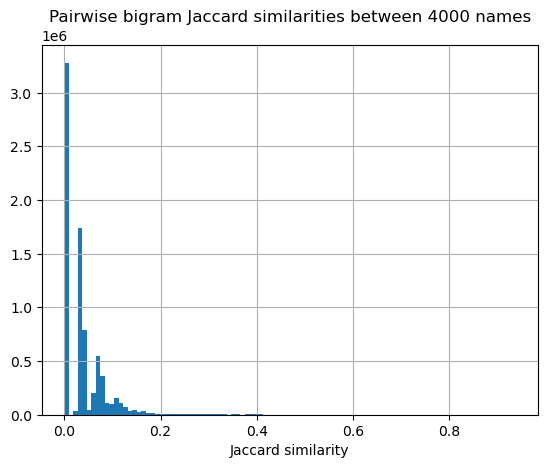

In [27]:
namesim.hist("J", bins=100)
plt.title("Pairwise bigram Jaccard similarities between 4000 names")
plt.xlabel("Jaccard similarity")

Let us show the pairs of names with the highest similarities :


In [28]:
namesim.sort_values("J", ascending=False)[0:10]

,name1,name2,J
4219941,"Barresi,Anthony","Baresi,Anthony",0.937500
7595947,"Gonzalez,Marcos","Gonzalez,Marco",0.823529
4870890,"Garcia,Roberto","Garcia,Robert",0.812500
3641329,"Campbell,Dewan","Campbell,Dean",0.812500
2739228,"Martinez,Louis","Martinez,Luis",0.812500
7375037,"Park,Michael","Parks,Michael",0.800000
6662855,"Fernandez,Antonio","Fernandes,Antonio",0.800000
2330831,"Cohan,Steven","Cohn,Steven",0.785714
127505,"King,Darrien","King,Darren",0.785714
4470733,"Rodriguez,Andres","Rodriguez,Andrew",0.777778


Staring at these names, I cannot tell if any of them are typos or if they are all correctly but similarly spelled names.  We would not know if multiple people on this list accidentally shared a first and last name.  

A spot check on three of the rows above shows that Mr. Barressi and Mr. Baresi, Mr. Park and Mr. Parks, and Mr Gonzalez and Mr. Gonzelez all have different employee id numbers.  Although we were able to use the Jaccard similarity to find names that were similar to each other, we have not found evidence of mis-encoded names or corrupt data that needs to be fixed.


[^*]: Murphy, A.H. The Finley Affair: A Signal Event in the History of Forecast Verification.
Weather and Forecasting v11, issue 1. (1996) p3-20. doi:10.1175/1520-0434(1996)011<0003:TFAASE>2.0.CO;2  )   

[^**]: Jaccard, Paul. The distribution of the flora in the alpine zone.  New Phytologist v11 no. 2 (1912) doi:  10.1111/j.1469-8137.1912.tb05611.x

[^***]:   T. T. Tanimoto, (1958) “An elementary mathematical theory of classification and prediction,” IBM Internal Report. 